In [1]:
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model

In [2]:
image_directory = r'D:\Projects\ODIR\ODIRCODE\PreprocessingCodes\Input_224/'


#Now let us read metadata to get our Y values (multiple lables)
df = pd.read_csv(r'D:\Projects\ODIR\ODIRCODE\Prepro\ground_truth\all\odirALL.csv')    
print(df.head())     # printing first five rows of the file
print(df.columns)

df = df.iloc[:23000]  #Loading only first 1000 datapoints for memory reasons 
#Need to read images using the tag from metadata.
#Otherwise, if read directly from the folder then images may not correspond to 
#the metadata from the csv file. 

            ID  Normal  Diabetes  Glaucoma  Cataract  AMD  Hypertension  \
0   0_left.jpg       0         0         0         1    0             0   
1  0_right.jpg       1         0         0         0    0             0   
2   1_left.jpg       1         0         0         0    0             0   
3  1_right.jpg       1         0         0         0    0             0   
4   2_left.jpg       0         1         0         0    0             0   

   Myopia  Others  Total  
0       0       0      1  
1       0       0      1  
2       0       0      1  
3       0       0      1  
4       0       1      2  
Index(['ID', 'Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD',
       'Hypertension', 'Myopia', 'Others', 'Total'],
      dtype='object')


In [3]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
SIZE = 224
X_dataset = []  
for i in tqdm(range(df.shape[0])):
    img = load_img(image_directory +df['ID'][i], target_size=(SIZE,SIZE,3))   
    img = img_to_array(img)
    img = img/255.
    X_dataset.append(img)

100%|███████████████████████████████████████████████████████████████████████████| 22032/22032 [01:27<00:00, 251.38it/s]


In [4]:
X = np.array(X_dataset)

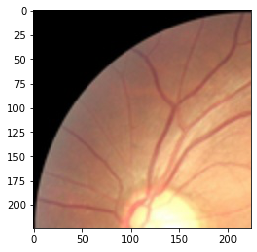

In [5]:
from matplotlib import pyplot as plt
plt.imshow(X[21000], interpolation='nearest')
plt.show()

In [6]:
#
print(df['ID'][500])  #King Kong

print(df['Total'][500])  #Tagged as multiple Genres.

#Id and Genre are not labels to be trained. So drop them from the dataframe.

268_left.jpg
2


In [7]:
y = np.array(df.drop(['ID', 'Total'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [8]:
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten
#from tensorflow.keras_efficientnets import *
#from tensorflow.python.keras.applications.efficientnet import *
#from tensorflow.keras_efficientnets import EfficientNetB3
#from tensorflow.keras import applications
#from tensorflow.keras.applications.efficientnet import EfficientNetB3
checkpoint1 = ModelCheckpoint(filepath=r'D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\my_best_model.epoch{epoch:03d}-loss{val_loss:.2f}.hdf5', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
checkpoint2 = ModelCheckpoint(filepath=r'D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\my_best_model.epoch{epoch:03d}-acc{val_accuracy:.2f}.hdf5', 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

callbacks = [checkpoint1,checkpoint2]
#EffB3 = EfficientNetB3(
  #  include_top=False,
   # weights='imagenet',
   # input_tensor=None,
   # input_shape=(224,224,3),
   # pooling=None,
   # classes=8
#)


XCEP = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=8
)

  #  classifier_activation="softmax",
 #   **kwargs
#res=tf.keras.applications.resnet.ResNet101(include_top=False,weights='imagenet',input_tensor=None,
   # input_shape=(224,224,3),
 #   pooling=None,
  #  classes=8)

#inc=InceptionV3(input_shape=(200,200,3),weights='imagenet', include_top=False)
for i in XCEP.layers:
    i.trainable=True
x=Flatten()(XCEP.output)
pred=Dense(8,activation='sigmoid')(x)
model=Model(inputs=XCEP.input,outputs=pred)

In [9]:
model.summary()

#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=100,callbacks=callbacks, validation_data=(X_test, y_test), batch_size=10)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

15420/15422 [============================>.] - ETA: 0s - loss: 0.3167 - accuracy: 0.8717
Epoch 00001: val_loss improved from inf to 0.28348, saving model to D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\my_best_model.epoch001-loss0.28.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.88026, saving model to D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\my_best_model.epoch001-acc0.88.hdf5
15422/15422 [==============================] - 165s 11ms/sample - loss: 0.3167 - accuracy: 0.8717 - val_loss: 0.2835 - val_accuracy: 0.8803
Epoch 2/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.2536 - accuracy: 0.8932
Epoch 00002: val_loss improved from 0.28348 to 0.22913, saving model to D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\my_best_model.epoch002-loss0.23.hdf5

Epoch 00002: val_accuracy improved from 0.88026 to 0.90248, saving model to D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\my_best_model.epoch002-acc0.90.hdf5
15422/15422 [================

Epoch 22/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9920
Epoch 00022: val_loss did not improve from 0.18770

Epoch 00022: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0228 - accuracy: 0.9920 - val_loss: 0.3587 - val_accuracy: 0.9187
Epoch 23/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0221 - accuracy: 0.9921
Epoch 00023: val_loss did not improve from 0.18770

Epoch 00023: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0221 - accuracy: 0.9921 - val_loss: 0.3670 - val_accuracy: 0.9190
Epoch 24/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9937
Epoch 00024: val_loss did not improve from 0.18770

Epoch 00024: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0185 - accuracy: 0.

Epoch 46/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9964
Epoch 00046: val_loss did not improve from 0.18770

Epoch 00046: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0108 - accuracy: 0.9964 - val_loss: 0.4629 - val_accuracy: 0.9186
Epoch 47/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9960
Epoch 00047: val_loss did not improve from 0.18770

Epoch 00047: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0115 - accuracy: 0.9960 - val_loss: 0.4524 - val_accuracy: 0.9196
Epoch 48/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9960
Epoch 00048: val_loss did not improve from 0.18770

Epoch 00048: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0119 - accuracy: 0.

Epoch 70/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9974
Epoch 00070: val_loss did not improve from 0.18770

Epoch 00070: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.5078 - val_accuracy: 0.9200
Epoch 71/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9975
Epoch 00071: val_loss did not improve from 0.18770

Epoch 00071: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.4658 - val_accuracy: 0.9207
Epoch 72/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9980
Epoch 00072: val_loss did not improve from 0.18770

Epoch 00072: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0066 - accuracy: 0.

Epoch 94/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9982
Epoch 00094: val_loss did not improve from 0.18770

Epoch 00094: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.4962 - val_accuracy: 0.9237
Epoch 95/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9986
Epoch 00095: val_loss did not improve from 0.18770

Epoch 00095: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.5718 - val_accuracy: 0.9179
Epoch 96/100
15420/15422 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9976 ETA: 1s - l
Epoch 00096: val_loss did not improve from 0.18770

Epoch 00096: val_accuracy did not improve from 0.92515
15422/15422 [==============================] - 153s 10ms/sample - loss: 0.0067 - 

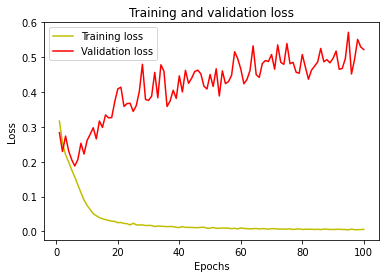

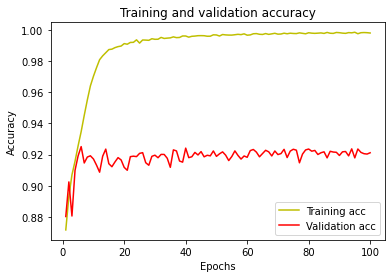

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
# MLP for Pima Indians Dataset saved to single file
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model.save(r"D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\model\modelke.h5")
print("Saved model to disk")
# evaluate the model
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# save model and architecture to single file
model.save(r"D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\model\ke2model.h5")
print("Saved model to disk")

Saved model to disk
accuracy: 99.85%
Saved model to disk


In [12]:
...
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
save_model(model, r"D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\model\model2.h5")

In [14]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense
import numpy
import os

# evaluate the model
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 
# serialize model to JSON
model_json = model.to_json()
with open(r"D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\model\model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(r"D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\model\modeljs.h5")
print("Saved model to disk")


accuracy: 99.85%
Saved model to disk


In [15]:
from tensorflow.keras.models import Sequential, model_from_yaml
from tensorflow.keras.layers import Dense
import numpy
import os

# serialize model to YAML
model_yaml = model.to_yaml()
with open(r"D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\model\model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights(r"D:\Projects\ODIR\ODIRCODE\bestres\xcepforreport100\model\modelya.h5")
print("Saved model to disk")
 


Saved model to disk
